In [5]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

#UP TO NOW WORKING ONLY WITHOUT CONSERVATION LAWS

# Function to read the stoichio matrices
def read_matrix_from_txt(file_path):
    return np.loadtxt(file_path, delimiter=' ')

S_minus = read_matrix_from_txt('S_minus.txt')
S_plus = read_matrix_from_txt('S_plus.txt')

# Note: chemostats_input must be given as a list of indices representing what species I want to chemostat (one or more)

def sensitivity(S_minus, S_plus, chemostats_input, law):

    # Making matrices sympy elements
    S_minus = sp.Matrix(S_minus)
    S_plus = sp.Matrix(S_plus)
    
    # Getting the number of reactions and species
    num_reactions = S_minus.shape[1]
    num_species = S_minus.shape[0]
    
    # Making species and rate consts sympy elements
    species = sp.symbols(f'X1:{num_species+1}')
    k = sp.symbols(f'k1:{num_reactions+1}')  
    km = sp.symbols(f'km1:{num_reactions+1}')  # Backwards rates
    
    # Constructing the sympy stoichio matrix and sympy vector of species
    S = S_minus - S_plus
    X = sp.Matrix(species)
    
    # Sympy vectors of currents, assuming MAL
    jplus = sp.Matrix([k[i] * sp.prod([X[j]**S_plus[j, i] for j in range(num_species)]) for i in range(num_reactions)])
    jminus = sp.Matrix([km[i] * sp.prod([X[j]**S_minus[j, i] for j in range(num_species)]) for i in range(num_reactions)])
    
    rate_eqs = jplus - jminus
    
    # Indices of the chosen chemostats
    chemo = chemostats_input

    # Chemostats in sympy format
    chemostats = [species[i] for i in chemo]
    
    # Choosing the species wrt solve S*j=0, hence the species which are not chemostated 
    state_vars_to_solve = [var for var in species if var not in chemostats]

    # Choosing the steady state equations, hence the dynamical equations for the species which are not chemostated 
    steady_state_eqs = sp.Matrix([S[row, :] * rate_eqs for row in range(num_species) if species[row] in state_vars_to_solve])
    #print(steady_state_eqs)
    # Solving S*j=0 for the non chemostated species, with the "non chemostated" reactions
    steady_state_solutions = sp.solve(steady_state_eqs, state_vars_to_solve)
    print(steady_state_solutions)
    
    #for i in range(len(steady_state_solutions)):
        #print(steady_state_solutions[i])
        #print("\n")
    
    if isinstance(steady_state_solutions, list):
        if len(steady_state_solutions) > 0:

            # Taking only the last solution, assuming that to be the correct steady state (STILL TO CHECK)
            steady_state_sol = steady_state_solutions[-1]
        else:
            raise ValueError("No solution can be computed for the steady state")
    else:
        # If there is only one solution, take that
        steady_state_sol = steady_state_solutions
    
    print("\nSteady states:")
    # Print the steady state solution
    print(steady_state_sol)
    
    # Transform it from a sympy matrix ( a dict with possible tuple format) into a list without commas, so it can be treated correclty afterwards 
    if isinstance(steady_state_sol, dict):
        steady_state_sol = list(steady_state_sol.values())
    elif isinstance(steady_state_sol, tuple):
        steady_state_sol = list(steady_state_sol)
    else:
        steady_state_sol = [steady_state_sol]
    
    
    # Computation of the log-sensitivities for all the non-chemostated species' steady state, wrt the forward rate consts
    sensitivities_k = [[(k[i] / ss)*sp.diff(ss, k[i]) for ss in steady_state_sol] for i in range(num_reactions)]
    
    # Computation of the log-sensitivities for all the non-chemostated species' steady state, wrt the backward rate consts
    sensitivities_km = [[(km[i] / ss)*sp.diff(ss, km[i]) for ss in steady_state_sol] for i in range(num_reactions)]
    
    # Computation of the log-sensitivities for all the non-chemostated species' steady state, wrt the chemostated species
    sensitivities_chemostats = [[(cs / ss)*sp.diff(ss, cs) for ss in steady_state_sol] for cs in chemostats]
    
    # Creation of a dictionary for each species with an associated list containing all the sensitivities for the specific species
    sens_results = {species[j]: [] for j in range(num_species) if j not in chemo}

    # Cycle to append, for each non-chemo species,
    for j in range(num_species):
        if j not in chemo:
            # Temporary list to append for the species sensitivity
            sens_list = []
            
            # Adding the sensitivity wrt chemos
            for i in range(len(chemo)):
                sens_list.append(sensitivities_chemostats[i][j - len(chemo)])  # Offset for the indices
            
            # Adding the sensitivity wrt k+ and k-
            for i in range(num_reactions):
                sens_list.append(sensitivities_k[i][j - len(chemo)])  # Offset for the indices
                sens_list.append(sensitivities_km[i][j - len(chemo)]) 
            
            # Adding the list to the dictionary for the specific non-chemostated species
            sens_results[species[j]] = sens_list
    
    # Printing the Sensitivities for each species
    for specie, sens_list in sens_results.items():
        print(f"\nSensitivity for {specie}: \n{sens_list}")

    #print(sensitivities_k[0][0])

    print("\nSensitivities:")
    print("Sensitivities wrt k+:")
    for sens in sensitivities_k:
        print(sens)
    
    print("\nSensitivities wrt k-:")
    for sens in sensitivities_km:
        print(sens)
    
    print("\nSensitivities wrt chemostats:")
    for sens in sensitivities_chemostats:
        print(sens)

    # Number of points for the cloud
    n_points = 1000

    # Fixing a random value for each chemostat
    chemo_values = np.random.randint(0, 6, size=len(chemo)).tolist()

    # For each species, cycle to substitute random constants to the sensitivities and append them in "sensitivity_results", to then plot all of them
    for specie, sens_list in sens_results.items():
        sensitivity_results = [[] for _ in range(2 * num_reactions + len(chemostats))]

        # Randomizing the constants for each realization, while keeping the chemostats fixed
        for i in range(n_points):
            k_values = np.random.uniform(0,1, size=num_reactions)
            mu_0 = np.random.uniform(-1, 1, size=num_species) # For the thermodynamical feasibility of the reactions

            S_numpy = np.array(S.evalf(), dtype=float)

            
            mu_0_vector = np.array(mu_0).reshape(-1, 1)
            DeltaG0 = np.dot(S_numpy.T, mu_0_vector).flatten()
        
            km_values = np.array(k_values) * np.exp(DeltaG0)  
        
            # Substituting the values into the sympy expressions
            substitutions_k = {k[i]: k_values[i] for i in range(len(k))}
            substitutions_km = {km[i]: km_values[i] for i in range(len(km))}
            substitutions_chemo = {chemostats[i]: chemo_values[i] for i in range(len(chemostats))}
            
            # Applying the substitutions into all the sensitivities for the species
            sens_substituted = [expr.subs(substitutions_k).subs(substitutions_km).subs(substitutions_chemo) for expr in sens_list]

            # Collecting them in a list for the species "specie"
            for idx, sens in enumerate(sens_substituted):
                sensitivity_results[idx].append(float(sens))


        # Plots creation
        fig, axes = plt.subplots(2 * num_reactions + len(chemostats), figsize=(12, 8), constrained_layout=True)
        fig.suptitle('Log-Sensitivities for species %s \n'%specie, fontsize=16)
        
        # Loop for each sensitivity to plot, always being fixed on the same non-chemo species
        for idx in range(2 * num_reactions + len(chemostats)):
            axes[idx].scatter(range(1, n_points + 1), sensitivity_results[idx], alpha=0.6)
        
            # Determining the variable we are differenting wrt to create the correct labels
            if idx < len(chemostats):
                variable = chemostats[idx] # If it ends here I am computing the sensitivity wrt chemos
            else:
                # If it ends here I am computing the sensitivity wrt k+ or k-
                reaction_index = idx - len(chemostats)
                if reaction_index % 2 == 0:  # k+
                    variable = k[reaction_index // 2]
                else:  # k-
                    variable = km[reaction_index // 2]

            # Latex format for the Y axis 
            axes[idx].set_ylabel(r'$\frac{d \log(' + str(specie) + ')}{d \log(' + str(variable) + ')}$',fontsize=12)
        
            axes[idx].set_xlabel('Realizations')
        plt.savefig("Sens.pdf")
        plt.show()


{X2: (X1**2*km2 + X1*k1)/(k2 + km1)}

Steady states:
{X2: (X1**2*km2 + X1*k1)/(k2 + km1)}

Sensitivity for X2: 
[X1*(2*X1*km2 + k1)/(X1**2*km2 + X1*k1), X1*k1/(X1**2*km2 + X1*k1), -km1/(k2 + km1), -k2/(k2 + km1), X1**2*km2/(X1**2*km2 + X1*k1)]

Sensitivities:
Sensitivities wrt k+:
[X1*k1/(X1**2*km2 + X1*k1)]
[-k2/(k2 + km1)]

Sensitivities wrt k-:
[-km1/(k2 + km1)]
[X1**2*km2/(X1**2*km2 + X1*k1)]

Sensitivities wrt chemostats:
[X1*(2*X1*km2 + k1)/(X1**2*km2 + X1*k1)]


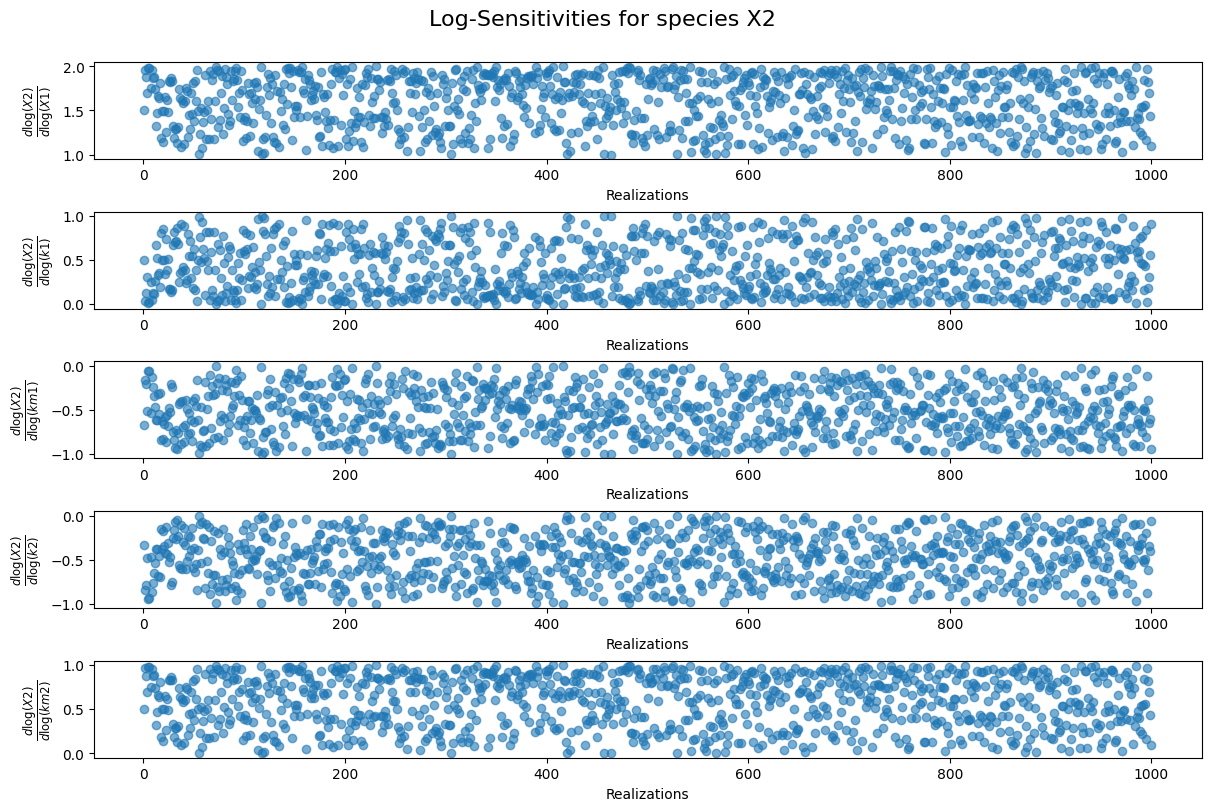

In [8]:
chemostats_input = [0] # The first species is chemostated in this example
law = "MAL"
sensitivity(S_minus, S_plus, chemostats_input, law)